In [79]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.layers import Dense, Input, LayerNormalization, Dropout, Add
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import MeanSquaredError
from skimage.metrics import structural_similarity as ssim
from skimage.metrics import peak_signal_noise_ratio as psnr
import tqdm
import os
import time

# 1. Load CIFAR-10 dataset

In [ ]:
(x_train, _), (x_test, _) = tf.keras.datasets.cifar10.load_data()
x_train = x_train.astype('float32') / 255.0
x_test = x_test.astype('float32') / 255.0

170498071/170498071 ━━━━━━━━━━━━━━━━━━━━ 17s 0us/step


# 2. Convert images to patches

In [ ]:
patch_size = 4  # 4x4 patches
image_height, image_width = 32, 32
def image_to_patches(images):
    patches = tf.image.extract_patches(
        images=images,
        sizes=[1, patch_size, patch_size, 1],
        strides=[1, patch_size, patch_size, 1],
        rates=[1, 1, 1, 1],
        padding="VALID"
    )
    patch_dims = patch_size * patch_size * 3
    return tf.reshape(patches, [tf.shape(images)[0], -1, patch_dims])

# 2. Convert patches to images

In [ ]:
def patches_to_image(patches):
    batch_size = tf.shape(patches)[0]
    patches = tf.reshape(patches, [batch_size, (image_height // patch_size)**2, patch_size, patch_size, 3])
    patch_rows = image_height // patch_size
    patch_cols = image_width // patch_size
    patches = tf.reshape(patches, [batch_size, patch_rows, patch_cols, patch_size, patch_size, 3])
    patches = tf.transpose(patches, [0, 1, 3, 2, 4, 5])
    images = tf.reshape(patches, [batch_size, image_height, image_width, 3])
    return images

In [ ]:
train_patches = image_to_patches(x_train)
test_patches = image_to_patches(x_test)
num_patches = train_patches.shape[1]
patch_dim = train_patches.shape[2]
print("Number of patches:", num_patches)
print("Patch dimension:", patch_dim)

Number of patches: 64
Patch dimension: 48


# 3. Create the ViT model

In [ ]:
def transformer_block(inputs, embed_dim, num_heads, ff_dim, dropout_rate=0.1):
    # Multi-head attention
    attention_output = LayerNormalization(epsilon=1e-6)(inputs)
    attention_output = tf.keras.layers.MultiHeadAttention(
        num_heads=num_heads, key_dim=embed_dim//num_heads
    )(attention_output, attention_output)
    attention_output = Dropout(dropout_rate)(attention_output)
    out1 = Add()([inputs, attention_output])

    # Feed Forward Network
    ffn_output = LayerNormalization(epsilon=1e-6)(out1)
    ffn_output = Dense(ff_dim, activation="gelu")(ffn_output)
    ffn_output = Dropout(dropout_rate)(ffn_output)
    ffn_output = Dense(embed_dim)(ffn_output)
    ffn_output = Dropout(dropout_rate)(ffn_output)

    return Add()([out1, ffn_output])

In [ ]:
def create_vit_model(num_layers=4, embed_dim=128, num_heads=8, ff_dim=256, dropout_rate=0.1):
    inputs = Input(shape=(num_patches, patch_dim))

    # Patch embedding
    x = Dense(embed_dim)(inputs)

    # Position embedding
    positions = tf.range(start=0, limit=num_patches, delta=1)
    pos_embed = tf.keras.layers.Embedding(input_dim=num_patches, output_dim=embed_dim)(positions)
    x = x + pos_embed

    # Transformer blocks
    for _ in range(num_layers):
        x = transformer_block(x, embed_dim, num_heads, ff_dim, dropout_rate)

    # Output layer
    x = LayerNormalization(epsilon=1e-6)(x)
    outputs = Dense(patch_dim, activation='sigmoid')(x)

    return Model(inputs=inputs, outputs=outputs)

# 4. Different masking strategies

In [ ]:
def random_masking(patches, ratio):
    """Random masking strategy"""
    batch_size, num_patches, _ = patches.shape
    mask = tf.cast(tf.random.uniform((batch_size, num_patches)) < ratio, tf.bool)
    mask_tokens = tf.zeros_like(patches)
    masked_patches = tf.where(tf.expand_dims(mask, -1), mask_tokens, patches)
    return masked_patches, mask

In [ ]:
def column_masking(patches, ratio):
    """Column-wise masking strategy"""
    batch_size = tf.shape(patches)[0]
    num_cols = int(np.sqrt(num_patches))

    # Calculate how many columns to mask
    cols_to_mask = int(num_cols * ratio)

    # Randomly select which columns to mask
    col_indices = tf.random.shuffle(tf.range(num_cols))[:cols_to_mask]

    # Create a mask tensor
    mask = tf.zeros((batch_size, num_patches), dtype=tf.bool)

    # For each column to mask, set the corresponding patches to True in the mask
    for col_idx in col_indices:
        patch_indices = tf.range(col_idx, num_patches, num_cols)
        indices = tf.stack([
            tf.repeat(tf.range(batch_size), tf.shape(patch_indices)[0]),
            tf.tile(patch_indices, [batch_size])
        ], axis=1)
        mask = tf.tensor_scatter_nd_update(
            mask,
            indices,
            tf.ones(tf.shape(indices)[0], dtype=tf.bool)
        )

    # Apply the mask
    mask_tokens = tf.zeros_like(patches)
    masked_patches = tf.where(tf.expand_dims(mask, -1), mask_tokens, patches)

    return masked_patches, mask

In [ ]:
def row_masking(patches, ratio):
    """Row-wise masking strategy"""
    batch_size = tf.shape(patches)[0]
    num_rows = int(np.sqrt(num_patches))
    patches_per_row = num_rows

    # Calculate how many rows to mask
    rows_to_mask = int(num_rows * ratio)

    # Randomly select which rows to mask
    row_indices = tf.random.shuffle(tf.range(num_rows))[:rows_to_mask]

    # Create a mask tensor
    mask = tf.zeros((batch_size, num_patches), dtype=tf.bool)

    # For each row to mask, set the corresponding patches to True in the mask
    for row_idx in row_indices:
        start_idx = row_idx * patches_per_row
        end_idx = start_idx + patches_per_row
        patch_indices = tf.range(start_idx, end_idx)

        indices = tf.stack([
            tf.repeat(tf.range(batch_size), tf.shape(patch_indices)[0]),
            tf.tile(patch_indices, [batch_size])
        ], axis=1)

        mask = tf.tensor_scatter_nd_update(
            mask,
            indices,
            tf.ones(tf.shape(indices)[0], dtype=tf.bool)
        )

    # Apply the mask
    mask_tokens = tf.zeros_like(patches)
    masked_patches = tf.where(tf.expand_dims(mask, -1), mask_tokens, patches)

    return masked_patches, mask

In [ ]:
def importance_based_masking(patches, ratio, model=None):
    """Mask patches based on importance (requires a trained model)"""
    if model is None:
        # Fallback to random masking if no model is provided
        return random_masking(patches, ratio)

    batch_size, num_patches, _ = patches.shape

    # Use the model to predict the importance of each patch
    with tf.GradientTape() as tape:
        tape.watch(patches)
        predictions = model(patches)
        # Use reconstruction loss as a measure of importance
        loss = tf.reduce_mean(tf.square(predictions - patches))

    # Get gradients with respect to input patches
    gradients = tape.gradient(loss, patches)
    importance = tf.reduce_mean(tf.abs(gradients), axis=-1)  # Average across patch dimensions

    # Create mask based on importance (mask least important patches)
    k = int(num_patches * ratio)
    _, indices = tf.nn.top_k(-importance, k=k)  # Get indices of least important patches

    # Create mask
    mask = tf.zeros((batch_size, num_patches), dtype=tf.bool)
    for i in range(batch_size):
        batch_indices = tf.stack([
            tf.repeat(i, k),
            indices[i]
        ], axis=1)
        mask = tf.tensor_scatter_nd_update(
            mask,
            batch_indices,
            tf.ones(k, dtype=tf.bool)
        )

    # Apply the mask
    mask_tokens = tf.zeros_like(patches)
    masked_patches = tf.where(tf.expand_dims(mask, -1), mask_tokens, patches)

    return masked_patches, mask

# 5. Create and compile the model

In [ ]:
vit_model = create_vit_model(
    num_layers=4,  # More layers for better representation
    embed_dim=128,  # Increased embedding dimension
    num_heads=4,    # Number of attention heads
    ff_dim=256,     # Feed-forward dimension
    dropout_rate=0.1  # Dropout for regularization
)
vit_model.compile(optimizer=Adam(0.001), loss=MeanSquaredError()) # or your desired optimizer


# 6. Training with learning rate scheduling and tracking

In [ ]:
def train_model(model, train_patches, mask_fn, mask_ratio=0.5, epochs=50, batch_size=128,
                validation_split=0.1, save_dir='saved_models'):

    # Create directory for saving models if it doesn't exist
    os.makedirs(save_dir, exist_ok=True)

    # Split into training and validation
    val_size = int(len(train_patches) * validation_split)
    train_ds = tf.data.Dataset.from_tensor_slices(train_patches[:-val_size]).shuffle(10000).batch(batch_size)
    val_ds = tf.data.Dataset.from_tensor_slices(train_patches[-val_size:]).batch(batch_size)

    # Initialize metrics tracking
    train_loss_history = []
    val_loss_history = []
    best_val_loss = float('inf')

    lr_schedule = tf.keras.callbacks.ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.5,
        patience=3,
        min_lr=0.0001
    )
    lr_schedule.set_model(model)


    loss_fn = MeanSquaredError()

    for epoch in range(epochs):
        print(f"\nEpoch {epoch+1}/{epochs}")
        start_time = time.time()

        # Training loop
        epoch_loss = []
        for batch in tqdm.tqdm(train_ds, desc="Training"):
            masked, mask = mask_fn(batch, mask_ratio)
            with tf.GradientTape() as tape:
                preds = model(masked, training=True)
                loss = loss_fn(tf.boolean_mask(batch, mask), tf.boolean_mask(preds, mask))
            grads = tape.gradient(loss, model.trainable_variables)
            model.optimizer.apply_gradients(zip(grads, model.trainable_variables))
            epoch_loss.append(loss.numpy())

        train_loss = np.mean(epoch_loss)
        train_loss_history.append(train_loss)

        # Validation loop
        val_losses = []
        for val_batch in tqdm.tqdm(val_ds, desc="Validation"):
            val_masked, val_mask = mask_fn(val_batch, mask_ratio)
            val_preds = model(val_masked, training=False)
            val_loss = loss_fn(tf.boolean_mask(val_batch, val_mask),
                               tf.boolean_mask(val_preds, val_mask))
            val_losses.append(val_loss.numpy())

        val_loss = np.mean(val_losses)
        val_loss_history.append(val_loss)

        # Update learning rate
        lr_schedule.on_epoch_end(epoch, {'val_loss': val_loss})

        # Save model if validation loss improved
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            model.save(f"{save_dir}/vit_mask_model_best.h5")
            print(f"Model saved at epoch {epoch+1}")

        # Print metrics
        elapsed_time = time.time() - start_time
        print(f"Epoch {epoch+1}/{epochs} - {elapsed_time:.1f}s - "
              f"loss: {train_loss:.4f} - val_loss: {val_loss:.4f} - "
              f"lr: {model.optimizer.learning_rate.numpy():.6f}")

    # Save final model
    model.save(f"{save_dir}/vit_mask_model_final.h5")

    return train_loss_history, val_loss_history

# 7. Evaluation (prediction)

In [ ]:
def evaluate_model(model, test_patches, mask_fn, mask_ratio=0.5):
    """Evaluate model using different metrics"""
    test_masked, mask = mask_fn(test_patches, mask_ratio)
    preds = model.predict(test_masked)
    reconstructed = tf.where(tf.expand_dims(mask, -1), preds, test_patches)

    # Convert to images for visual metrics
    recon_images = patches_to_image(reconstructed)
    original_images = patches_to_image(test_patches)

    # Calculate metrics
    mse_list = []
    ssim_list = []
    psnr_list = []

    for i in range(len(original_images)):
        mse_val = np.mean((original_images[i].numpy() - recon_images[i].numpy())**2)
        ssim_val = ssim(original_images[i].numpy(), recon_images[i].numpy(),
                        win_size=7, channel_axis=-1, data_range=1.0)
        psnr_val = psnr(original_images[i].numpy(), recon_images[i].numpy(), data_range=1.0)

        mse_list.append(mse_val)
        ssim_list.append(ssim_val)
        psnr_list.append(psnr_val)

    metrics = {
        'MSE': np.mean(mse_list),
        'SSIM': np.mean(ssim_list),
        'PSNR': np.mean(psnr_list)
    }

    print(f"Evaluation Metrics:")
    print(f"MSE: {metrics['MSE']:.4f}")
    print(f"SSIM: {metrics['SSIM']:.4f} (higher is better)")
    print(f"PSNR: {metrics['PSNR']:.2f} dB (higher is better)")

    return metrics, original_images, recon_images, test_masked

# 8. reconstruction

In [86]:
def visualize_reconstructions(originals, masked, reconstructed, num_samples=5):
    """Visualize original, masked and reconstructed images"""
    plt.figure(figsize=(15, 9))

    for i in range(num_samples):
        # Original image
        plt.subplot(3, num_samples, i + 1)
        plt.imshow(originals[i])
        plt.title("Original")
        plt.axis('off')

        # Masked image
        plt.subplot(3, num_samples, i + num_samples + 1)
        masked_image = masked[i] if isinstance(masked, np.ndarray) else masked[i].numpy()
        plt.imshow(masked_image)
        plt.title("Masked (50%)")
        plt.axis('off')

        # Reconstructed image
        plt.subplot(3, num_samples, i + 2*num_samples + 1)
        recon_image = reconstructed[i] if isinstance(reconstructed, np.ndarray) else reconstructed[i].numpy()
        plt.imshow(recon_image)
        plt.title("Reconstructed")
        plt.axis('off')

    plt.tight_layout()
    plt.show()

# 9. comparing masking methods

In [ ]:
def compare_masking_strategies(model, test_patches, ratios=[0.3, 0.5, 0.7]):
    """Compare different masking strategies across different masking ratios"""
    strategies = {
        'Random': random_masking,
        'Column': column_masking,
        'Row': row_masking
    }

    results = {}

    for strategy_name, mask_fn in strategies.items():
        strategy_results = {}

        for ratio in ratios:
            print(f"\nEvaluating {strategy_name} masking with ratio {ratio}")
            metrics, originals, reconstructed, masked_patches = evaluate_model(
                model, test_patches[:100], mask_fn, ratio
            )

            strategy_results[ratio] = {
                'metrics': metrics,
                'samples': {
                    'originals': originals[:5],
                    'masked': patches_to_image(masked_patches)[:5],
                    'reconstructed': reconstructed[:5]
                }
            }

            # Visualize some examples
            print(f"Visualization for {strategy_name} masking at {ratio*100}% ratio:")
            visualize_reconstructions(
                originals[:5],
                patches_to_image(masked_patches)[:5],
                reconstructed[:5]
            )

        results[strategy_name] = strategy_results

    return results

# 10. comparing metrics

In [ ]:
def plot_comparison_metrics(results, metric='SSIM'):
    """Plot comparison of metrics across different strategies and ratios"""
    ratios = list(next(iter(results.values())).keys())
    strategies = list(results.keys())

    plt.figure(figsize=(10, 6))

    for strategy in strategies:
        metric_values = [results[strategy][ratio]['metrics'][metric] for ratio in ratios]
        plt.plot([float(r)*100 for r in ratios], metric_values, 'o-', label=strategy)

    plt.xlabel('Masking Ratio (%)')
    plt.ylabel(metric)
    plt.title(f'{metric} vs Masking Ratio for Different Strategies')
    plt.legend()
    plt.grid(True)
    plt.show()

# 11. Implementation

## Set training parameters

In [ ]:
    EPOCHS = 20
    BATCH_SIZE = 128
    MASK_RATIO = 0.5

## Train with random masking (basic approach)

In [ ]:
    print("Training ViT with random masking...")
    train_losses, val_losses = train_model(
        vit_model,
        train_patches,
        random_masking,
        mask_ratio=MASK_RATIO,
        epochs=EPOCHS,
        batch_size=BATCH_SIZE
    )

Training ViT with random masking...

Epoch 1/20


Validation: 100%|██████████| 40/40 [00:40<00:00,  1.02s/it]


Model saved at epoch 1
Epoch 1/20 - 1060.4s - loss: 0.0388 - val_loss: 0.0345 - lr: 0.001000

Epoch 2/20


Validation: 100%|██████████| 40/40 [00:40<00:00,  1.02s/it]


Model saved at epoch 2
Epoch 2/20 - 1036.1s - loss: 0.0334 - val_loss: 0.0302 - lr: 0.001000

Epoch 3/20


Validation: 100%|██████████| 40/40 [00:40<00:00,  1.02s/it]


Model saved at epoch 3
Epoch 3/20 - 1083.2s - loss: 0.0313 - val_loss: 0.0293 - lr: 0.001000

Epoch 4/20


Validation: 100%|██████████| 40/40 [00:40<00:00,  1.02s/it]


Model saved at epoch 4
Epoch 4/20 - 1024.4s - loss: 0.0291 - val_loss: 0.0265 - lr: 0.001000

Epoch 5/20


Validation: 100%|██████████| 40/40 [00:40<00:00,  1.02s/it]


Model saved at epoch 5
Epoch 5/20 - 1033.9s - loss: 0.0267 - val_loss: 0.0227 - lr: 0.001000

Epoch 6/20


Validation: 100%|██████████| 40/40 [00:40<00:00,  1.02s/it]


Model saved at epoch 6
Epoch 6/20 - 1076.9s - loss: 0.0230 - val_loss: 0.0194 - lr: 0.001000

Epoch 7/20


Validation: 100%|██████████| 40/40 [00:40<00:00,  1.02s/it]


Epoch 7/20 - 1082.9s - loss: 0.0210 - val_loss: 0.0200 - lr: 0.001000

Epoch 8/20


Validation: 100%|██████████| 40/40 [00:40<00:00,  1.02s/it]


Model saved at epoch 8
Epoch 8/20 - 1034.0s - loss: 0.0198 - val_loss: 0.0169 - lr: 0.001000

Epoch 9/20


Validation: 100%|██████████| 40/40 [00:25<00:00,  1.56it/s]


Model saved at epoch 9
Epoch 9/20 - 1029.8s - loss: 0.0188 - val_loss: 0.0163 - lr: 0.001000

Epoch 10/20


Validation: 100%|██████████| 40/40 [00:40<00:00,  1.02s/it]


Model saved at epoch 10
Epoch 10/20 - 1038.5s - loss: 0.0182 - val_loss: 0.0161 - lr: 0.001000

Epoch 11/20


Validation: 100%|██████████| 40/40 [00:27<00:00,  1.45it/s]


Model saved at epoch 11
Epoch 11/20 - 1023.9s - loss: 0.0175 - val_loss: 0.0153 - lr: 0.001000

Epoch 12/20


Validation: 100%|██████████| 40/40 [00:25<00:00,  1.59it/s]


Model saved at epoch 12
Epoch 12/20 - 1067.2s - loss: 0.0168 - val_loss: 0.0146 - lr: 0.001000

Epoch 13/20


Validation: 100%|██████████| 40/40 [00:25<00:00,  1.60it/s]


Epoch 13/20 - 1052.2s - loss: 0.0165 - val_loss: 0.0147 - lr: 0.001000

Epoch 14/20


Validation: 100%|██████████| 40/40 [00:25<00:00,  1.58it/s]


Epoch 14/20 - 1022.8s - loss: 0.0163 - val_loss: 0.0150 - lr: 0.001000

Epoch 15/20


Validation: 100%|██████████| 40/40 [00:25<00:00,  1.57it/s]


Model saved at epoch 15
Epoch 15/20 - 1067.7s - loss: 0.0156 - val_loss: 0.0138 - lr: 0.001000

Epoch 16/20


Validation: 100%|██████████| 40/40 [00:25<00:00,  1.58it/s]


Epoch 16/20 - 1032.5s - loss: 0.0151 - val_loss: 0.0140 - lr: 0.001000

Epoch 17/20


Validation: 100%|██████████| 40/40 [00:25<00:00,  1.57it/s]


Model saved at epoch 17
Epoch 17/20 - 1067.6s - loss: 0.0150 - val_loss: 0.0132 - lr: 0.001000

Epoch 18/20


Validation: 100%|██████████| 40/40 [00:40<00:00,  1.02s/it]


Epoch 18/20 - 1082.9s - loss: 0.0145 - val_loss: 0.0132 - lr: 0.001000

Epoch 19/20


Validation: 100%|██████████| 40/40 [00:40<00:00,  1.02s/it]


Model saved at epoch 19
Epoch 19/20 - 1083.1s - loss: 0.0141 - val_loss: 0.0130 - lr: 0.001000

Epoch 20/20


Validation: 100%|██████████| 40/40 [00:40<00:00,  1.02s/it]


Model saved at epoch 20
Epoch 20/20 - 1083.1s - loss: 0.0142 - val_loss: 0.0127 - lr: 0.001000



# Plot curves

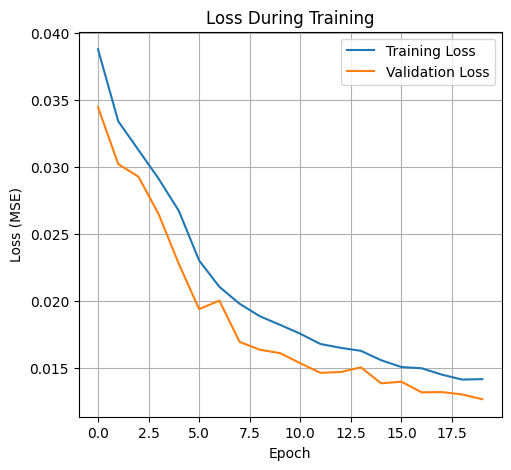

In [ ]:
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(train_losses, label='Training Loss')
    plt.plot(val_losses, label='Validation Loss')
    plt.title('Loss During Training')
    plt.xlabel('Epoch')
    plt.ylabel('Loss (MSE)')
    plt.legend()
    plt.grid(True)

## Evaluate on test set

In [ ]:
    print("\nEvaluating model on test set...")
    metrics, originals, reconstructed, masked = evaluate_model(
        vit_model, test_patches, random_masking, MASK_RATIO
    )


Evaluating model on test set...
313/313 ━━━━━━━━━━━━━━━━━━━━ 37s 118ms/step
Evaluation Metrics:
MSE: 0.0065
SSIM: 0.8047 (higher is better)
PSNR: 22.75 dB (higher is better)


## Visualizing some reconstructions


Visualizing reconstructions...


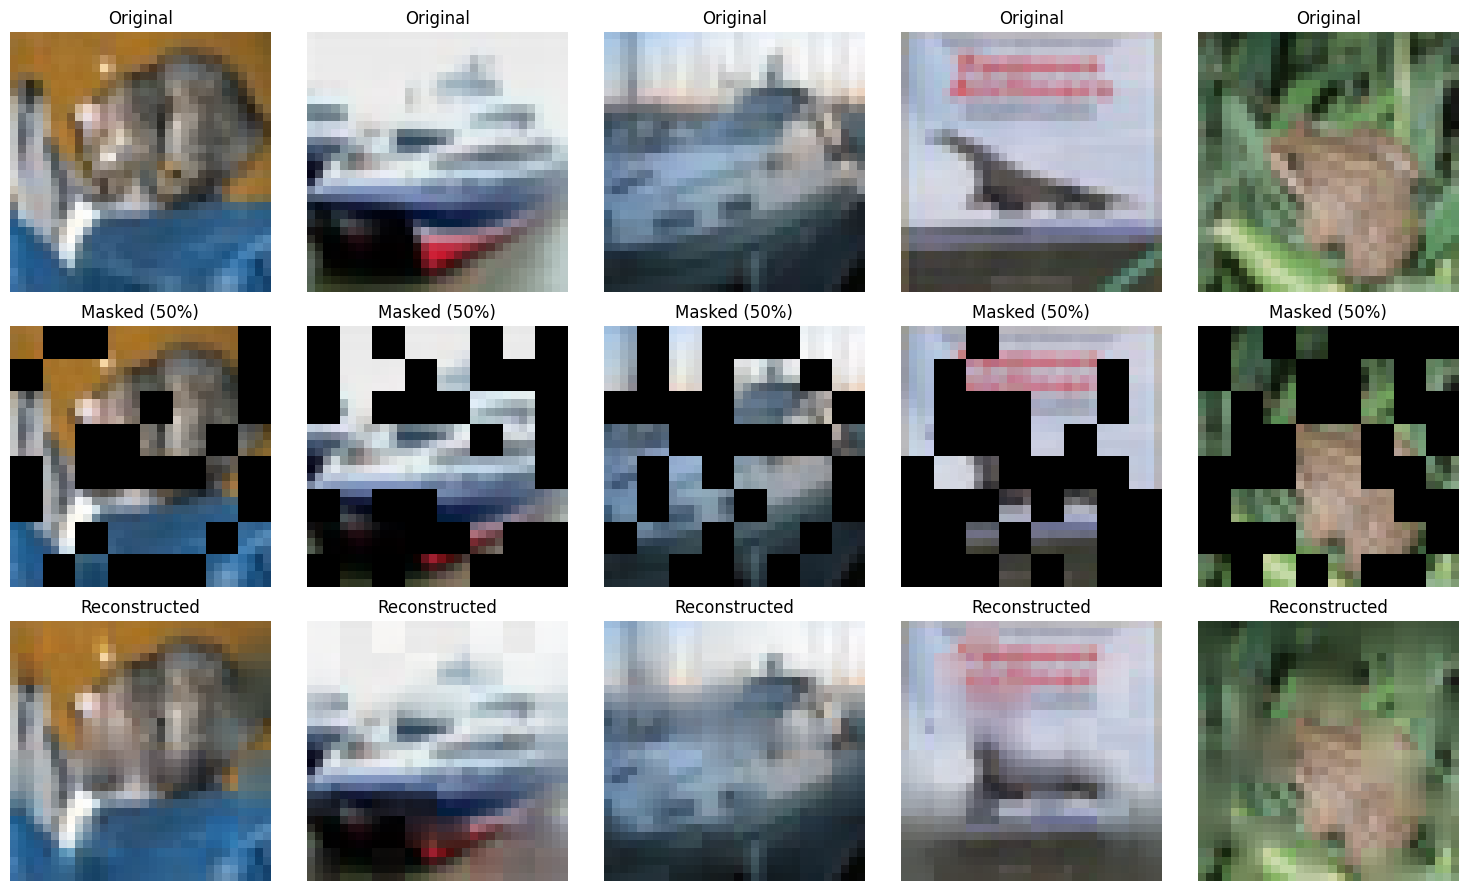

In [87]:
    print("\nVisualizing reconstructions...")
    visualize_reconstructions(
        originals[:5],
        patches_to_image(masked)[:5],
        reconstructed[:5]
    )

## Comparing different masking strategies


Comparing different masking strategies...

Evaluating Random masking with ratio 0.3
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 159ms/step
Evaluation Metrics:
MSE: 0.0030
SSIM: 0.9029 (higher is better)
PSNR: 26.10 dB (higher is better)
Visualization for Random masking at 30.0% ratio:


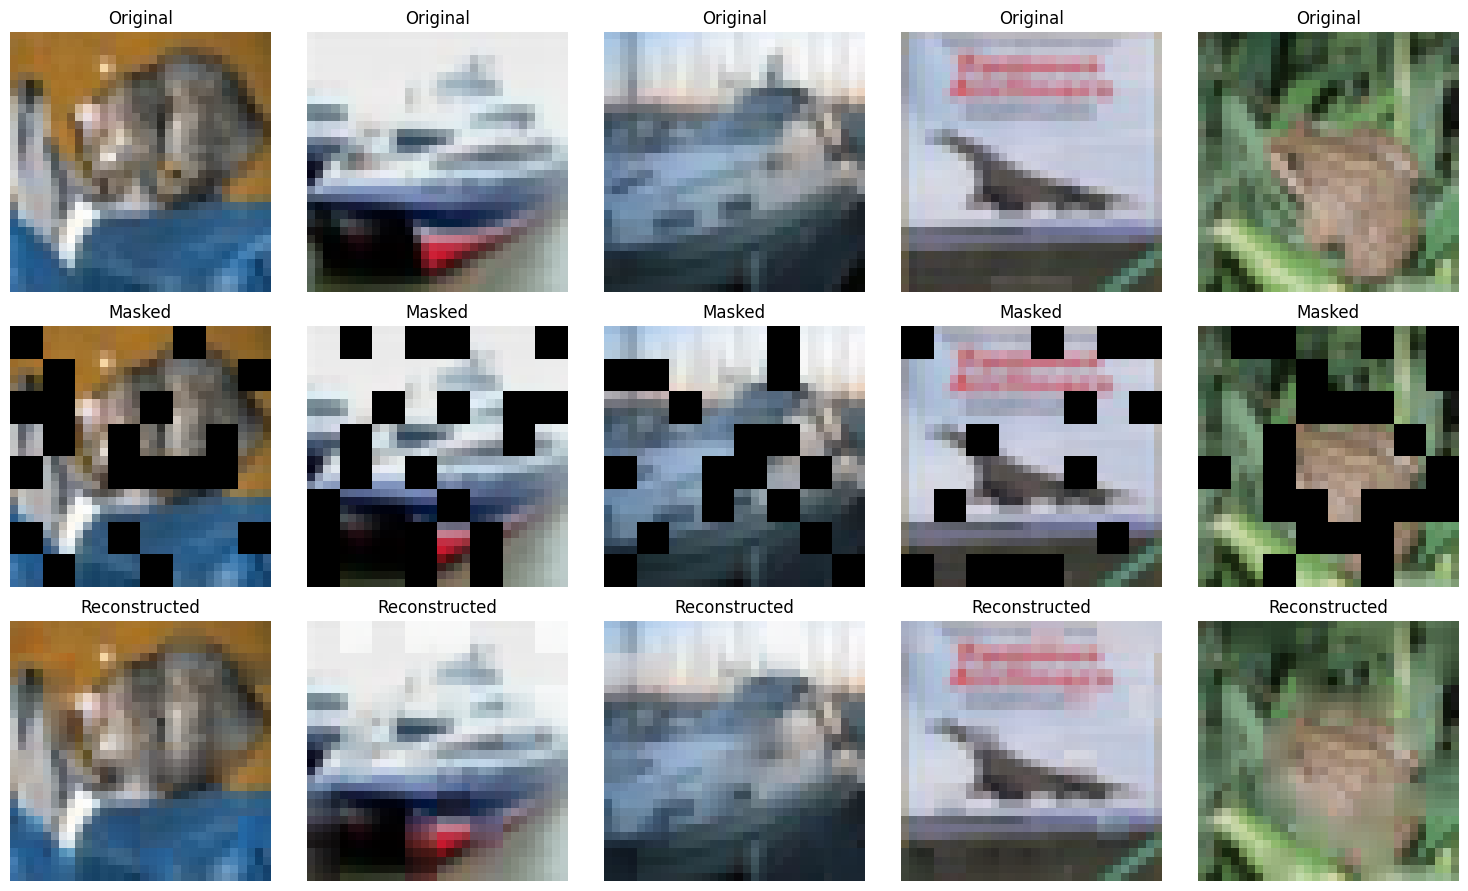


Evaluating Random masking with ratio 0.5
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step 
Evaluation Metrics:
MSE: 0.0063
SSIM: 0.8037 (higher is better)
PSNR: 22.84 dB (higher is better)
Visualization for Random masking at 50.0% ratio:


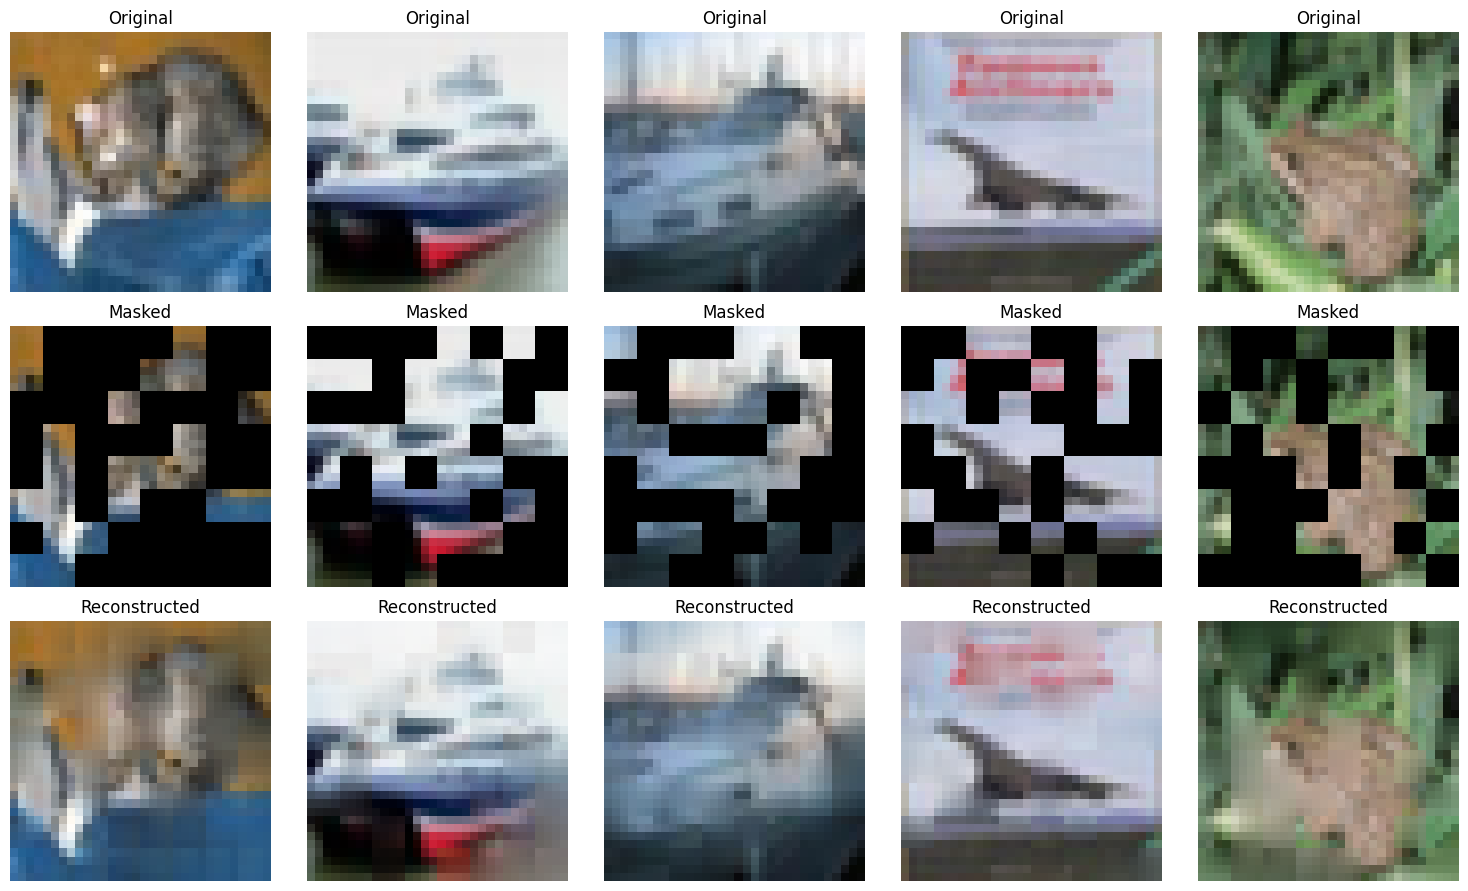


Evaluating Random masking with ratio 0.7
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step 
Evaluation Metrics:
MSE: 0.0131
SSIM: 0.6413 (higher is better)
PSNR: 19.60 dB (higher is better)
Visualization for Random masking at 70.0% ratio:


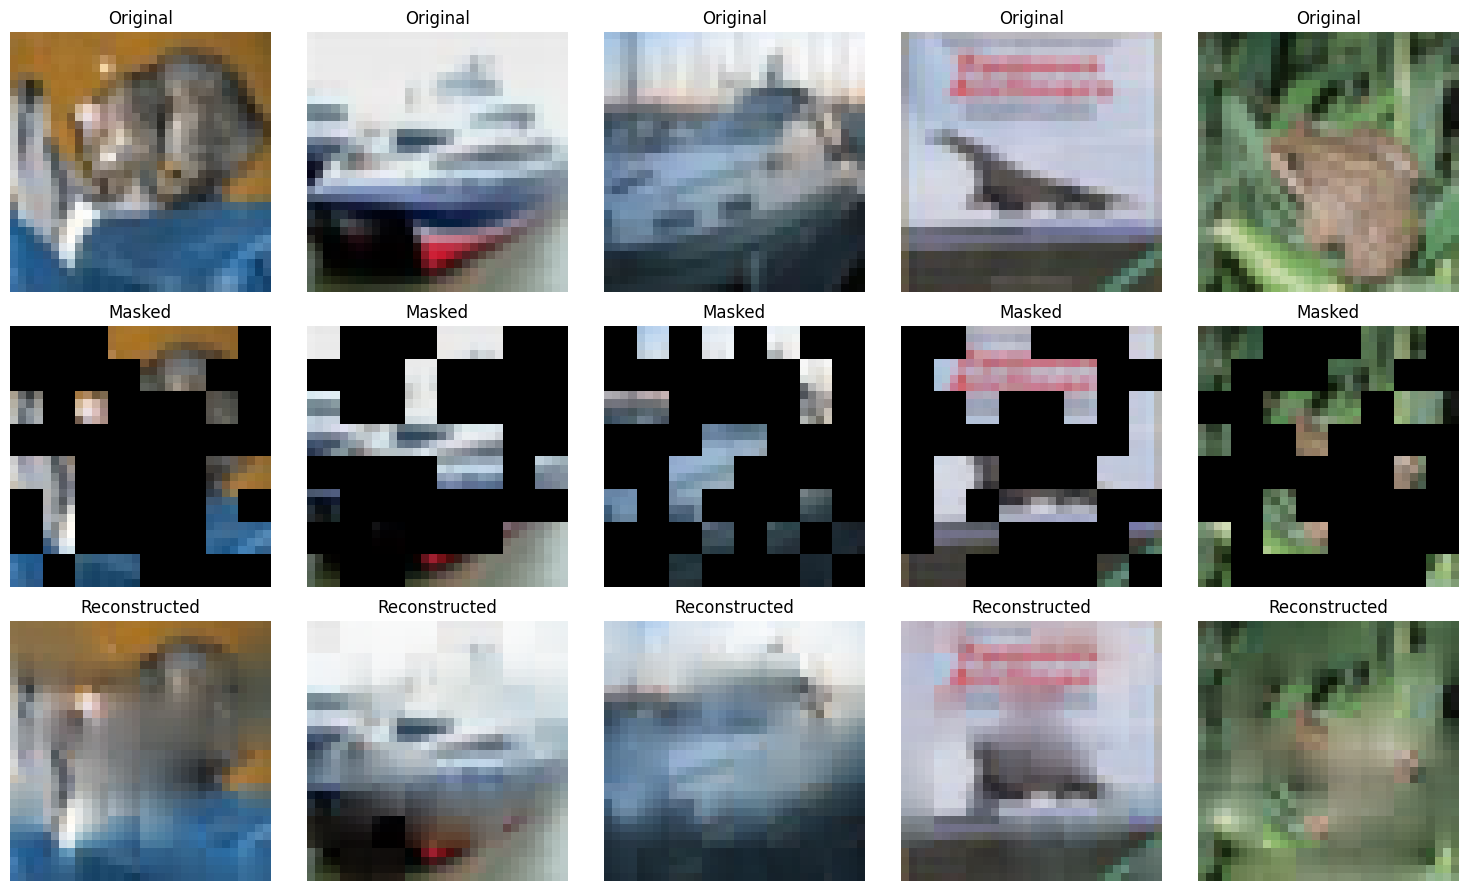


Evaluating Column masking with ratio 0.3
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step 
Evaluation Metrics:
MSE: 0.0028
SSIM: 0.8952 (higher is better)
PSNR: 26.33 dB (higher is better)
Visualization for Column masking at 30.0% ratio:


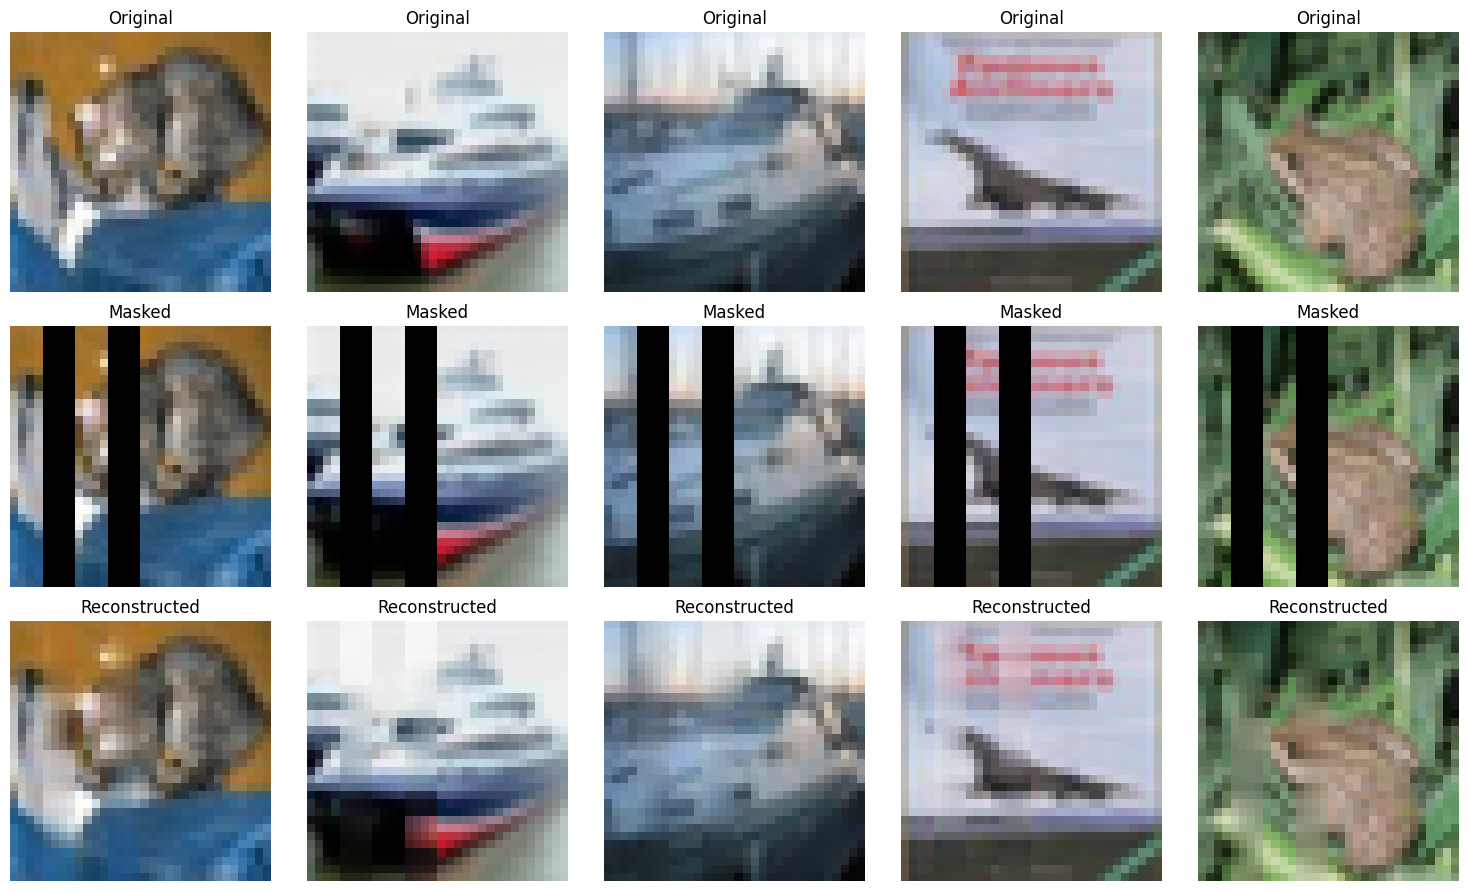


Evaluating Column masking with ratio 0.5
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step 
Evaluation Metrics:
MSE: 0.0090
SSIM: 0.7862 (higher is better)
PSNR: 21.42 dB (higher is better)
Visualization for Column masking at 50.0% ratio:


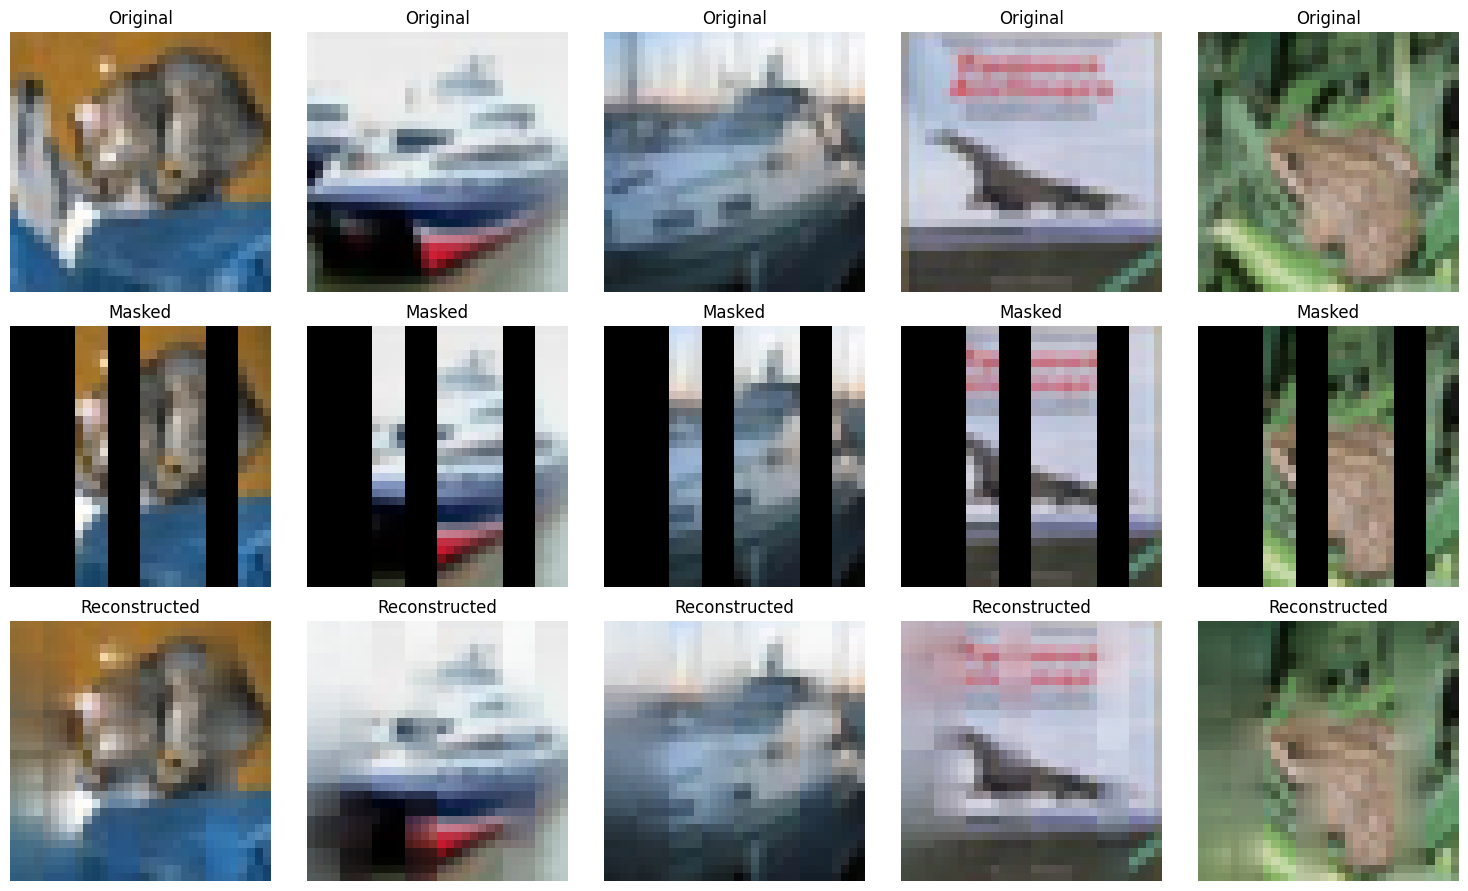


Evaluating Column masking with ratio 0.7
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step 
Evaluation Metrics:
MSE: 0.0163
SSIM: 0.6866 (higher is better)
PSNR: 18.73 dB (higher is better)
Visualization for Column masking at 70.0% ratio:


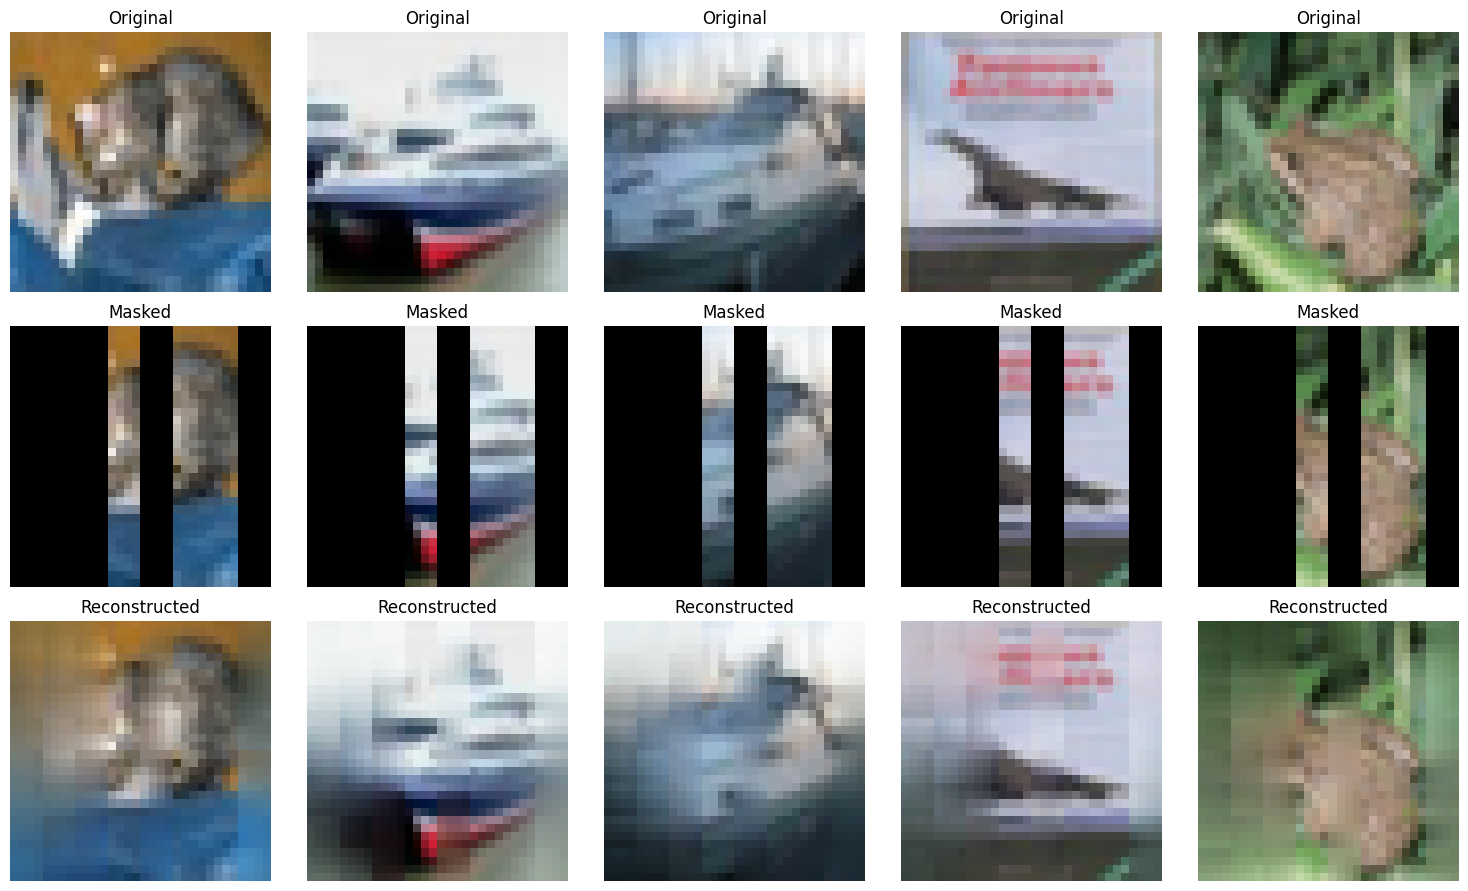


Evaluating Row masking with ratio 0.3
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 135ms/step
Evaluation Metrics:
MSE: 0.0029
SSIM: 0.8950 (higher is better)
PSNR: 26.51 dB (higher is better)
Visualization for Row masking at 30.0% ratio:


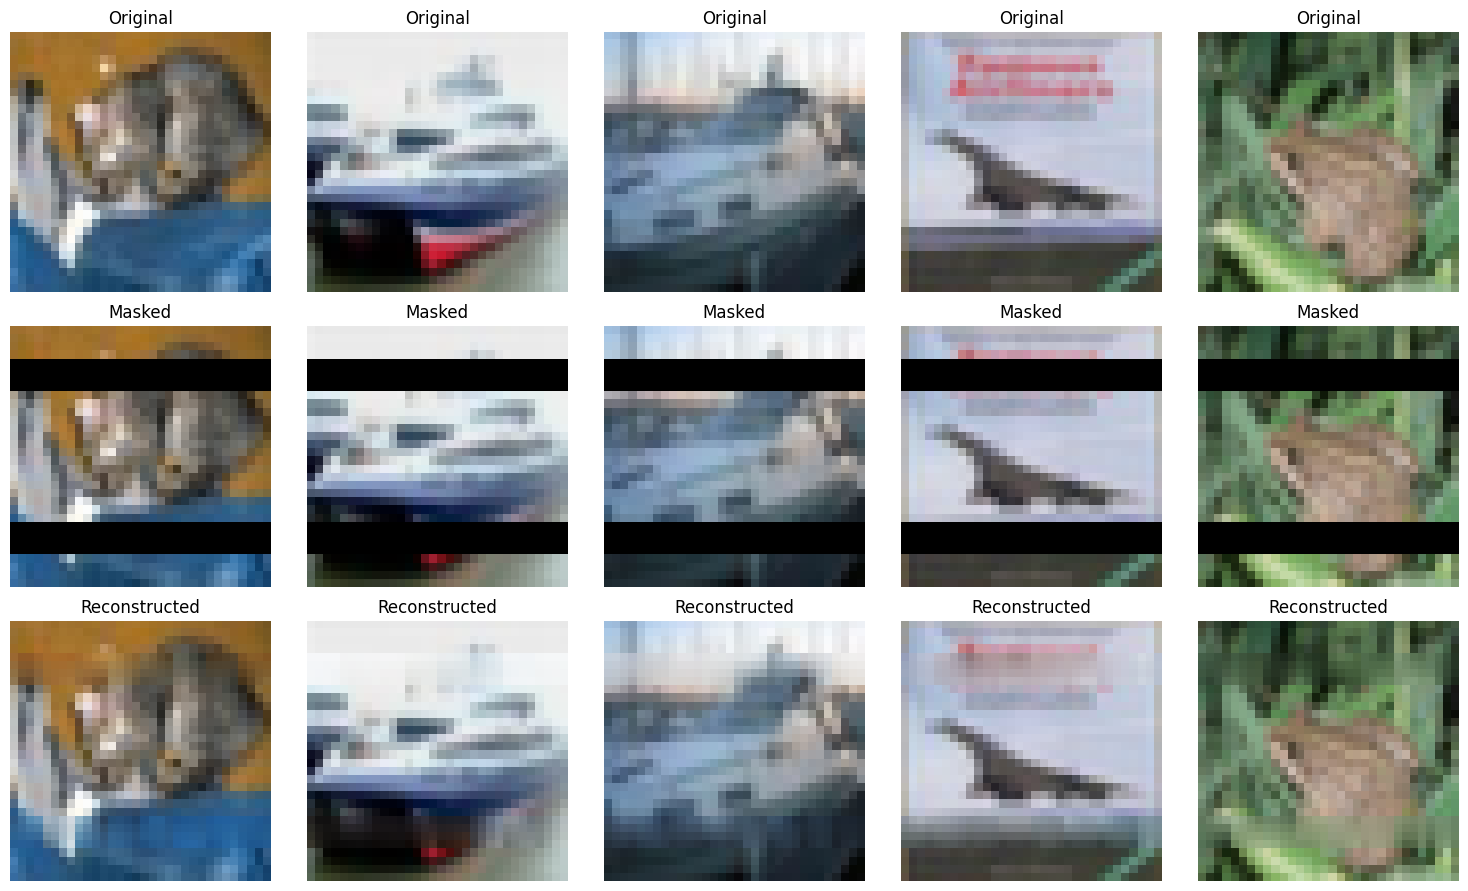


Evaluating Row masking with ratio 0.5
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step 
Evaluation Metrics:
MSE: 0.0106
SSIM: 0.7706 (higher is better)
PSNR: 20.62 dB (higher is better)
Visualization for Row masking at 50.0% ratio:


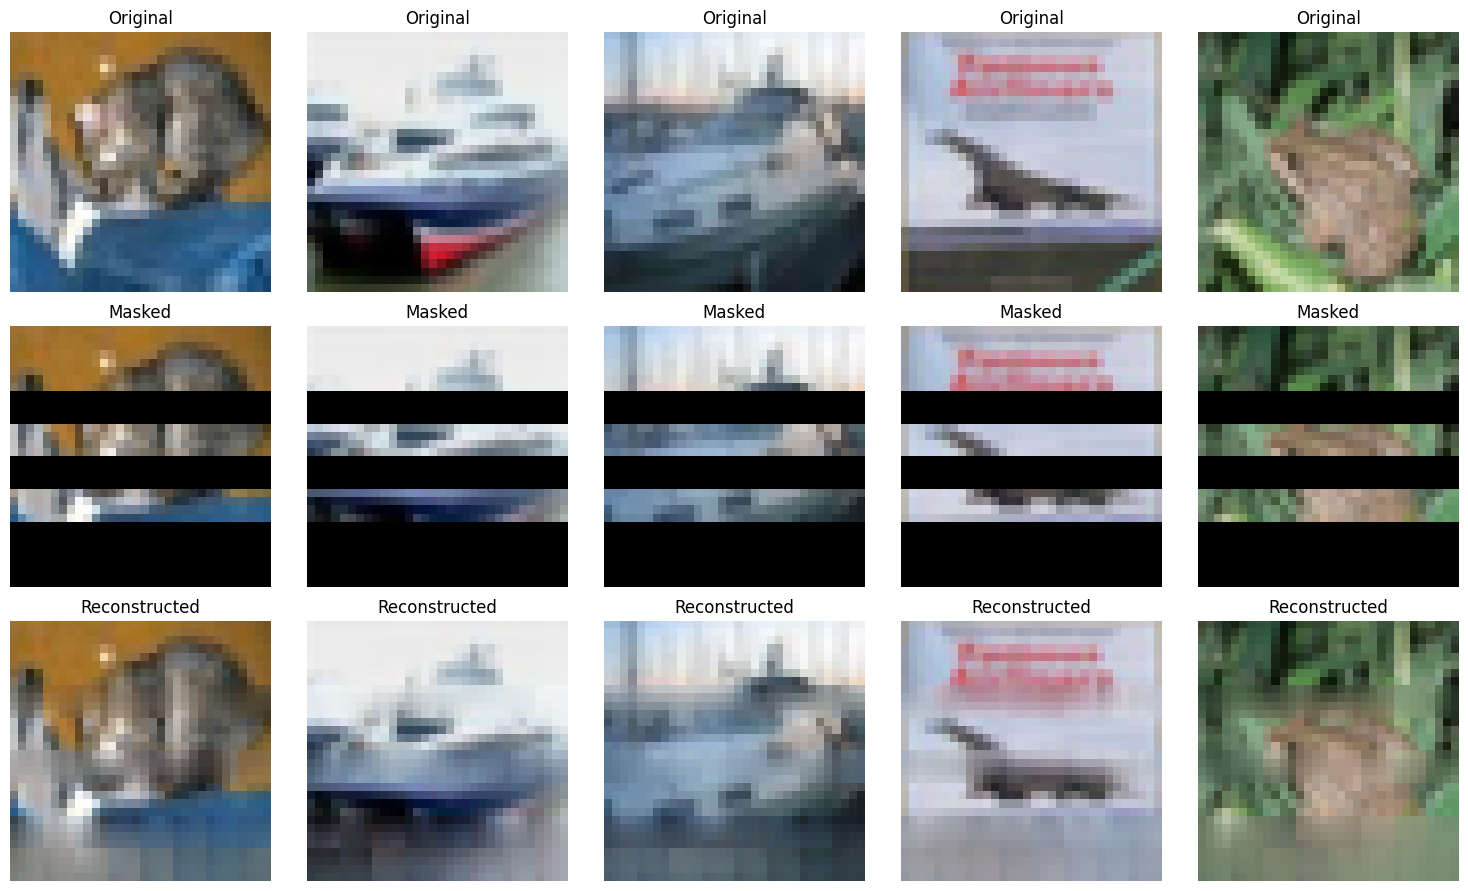


Evaluating Row masking with ratio 0.7
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step 
Evaluation Metrics:
MSE: 0.0168
SSIM: 0.5894 (higher is better)
PSNR: 18.42 dB (higher is better)
Visualization for Row masking at 70.0% ratio:


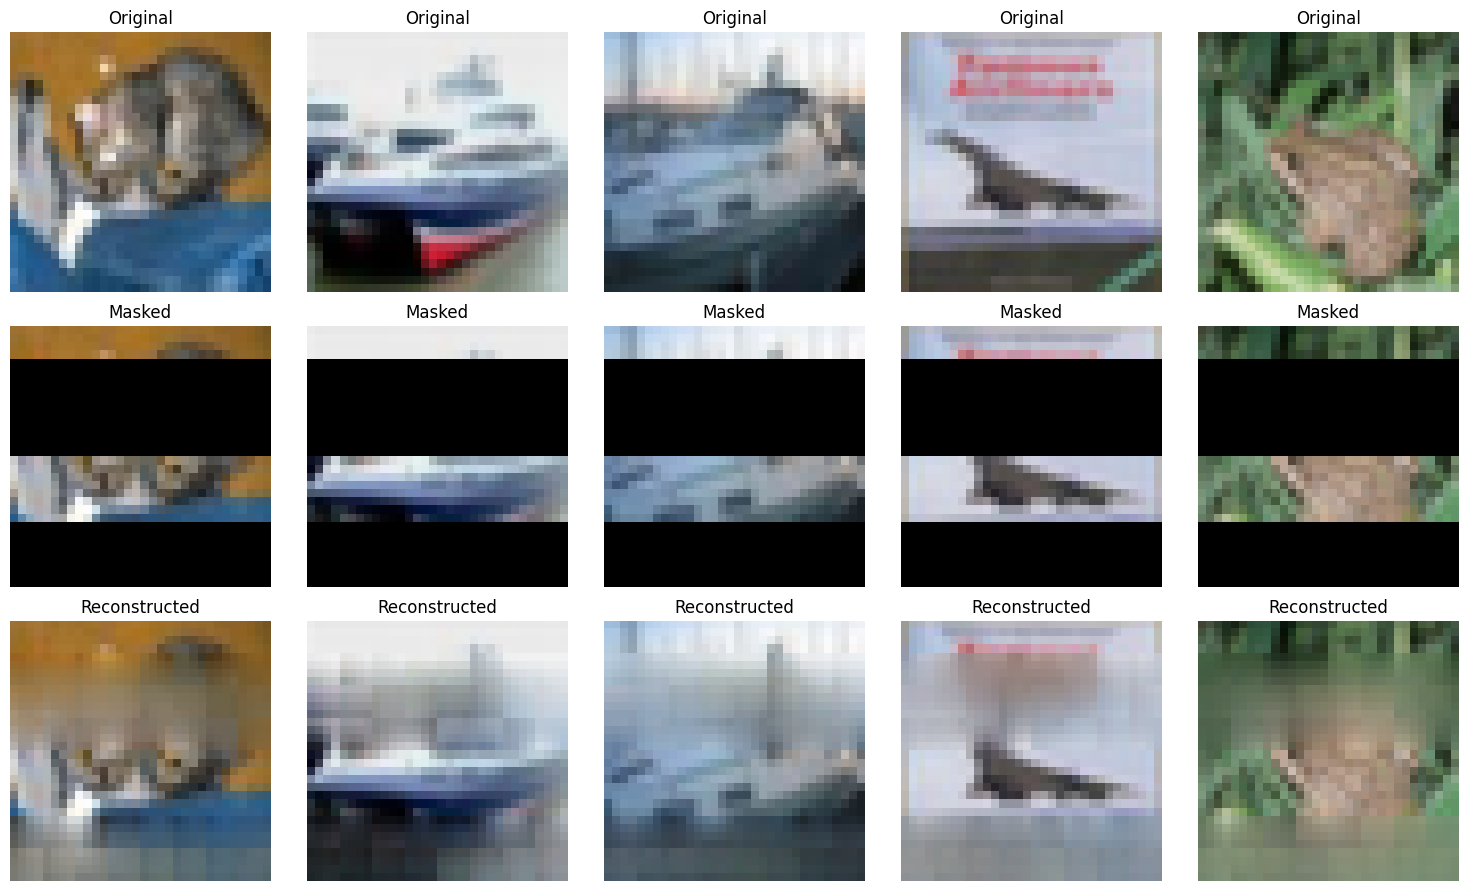


Plotting comparison metrics...


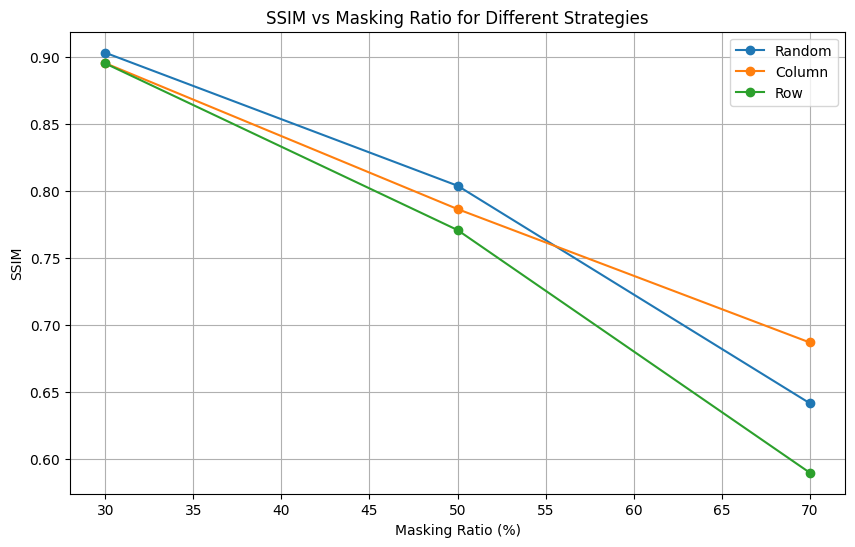

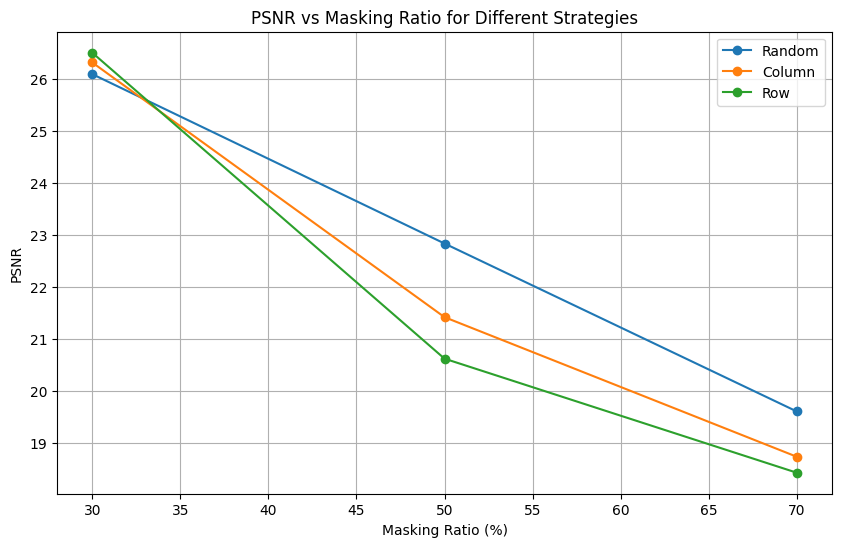

In [ ]:
print("\nComparing different masking strategies...")
strategies_results = compare_masking_strategies(
    vit_model,
    test_patches[:500],  # Use a subset for efficiency
    ratios=[0.3, 0.5, 0.7]
    )

# Plot comparison metrics
print("\nPlotting comparison metrics...")
plot_comparison_metrics(strategies_results, 'SSIM')
plot_comparison_metrics(strategies_results, 'PSNR')

#autoencodeur

In [80]:
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, Flatten, Dense, Reshape  # Import necessary layers
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import MeanSquaredError

## 1. Creation of the autoencoder

In [ ]:
def create_autoencoder():
    # Encoder
    input_img = Input(shape=(32, 32, 3))

    # Encoder path
    x = Conv2D(32, (3, 3), activation='relu', padding='same')(input_img)
    x = MaxPooling2D((2, 2), padding='same')(x)
    x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)
    x = MaxPooling2D((2, 2), padding='same')(x)
    x = Conv2D(128, (3, 3), activation='relu', padding='same')(x)
    x = MaxPooling2D((2, 2), padding='same')(x)  # 4x4x128

    # Bottleneck
    x = Flatten()(x)
    encoded = Dense(128, activation='relu')(x)  # Bottleneck representation

    # Decoder path
    x = Dense(4 * 4 * 128, activation='relu')(encoded)
    x = Reshape((4, 4, 128))(x)
    x = Conv2D(128, (3, 3), activation='relu', padding='same')(x)
    x = UpSampling2D((2, 2))(x)
    x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)
    x = UpSampling2D((2, 2))(x)
    x = Conv2D(32, (3, 3), activation='relu', padding='same')(x)
    x = UpSampling2D((2, 2))(x)
    decoded = Conv2D(3, (3, 3), activation='sigmoid', padding='same')(x)

    # Create and compile the autoencoder
    autoencoder = Model(input_img, decoded)
    autoencoder.compile(optimizer=Adam(0.001), loss=MeanSquaredError())

    return autoencoder

## 2. adding noise or mask to images

In [ ]:
def add_noise_to_images(images, noise_factor=0.5):
    """Add random noise to images to simulate masking in the ViT approach"""
    noisy_images = images + noise_factor * np.random.normal(loc=0.0, scale=1.0, size=images.shape)
    return np.clip(noisy_images, 0., 1.)

In [ ]:
# 3. Create a function to add mask-like patterns for fair comparison
def add_mask_noise(images, mask_ratio=0.5):
    """Add mask-like noise (some pixels set to zero) to images"""
    mask = np.random.random(images.shape) < mask_ratio
    masked_images = images.copy()
    masked_images[mask] = 0
    return masked_images

## 4. training the autoencoder

In [ ]:
def train_autoencoder(autoencoder, x_train, x_test, noise_type='random',
                      noise_factor=0.5, mask_ratio=0.5, epochs=20, batch_size=128):
    """Train autoencoder with different types of noise/masking"""

    # Prepare noisy/masked data based on noise_type
    if noise_type == 'random':
        x_train_noisy = add_noise_to_images(x_train, noise_factor)
        x_test_noisy = add_noise_to_images(x_test, noise_factor)
    elif noise_type == 'mask':
        x_train_noisy = add_mask_noise(x_train, mask_ratio)
        x_test_noisy = add_mask_noise(x_test, mask_ratio)
    else:
        raise ValueError("noise_type must be 'random' or 'mask'")

    # Train the autoencoder
    history = autoencoder.fit(
        x_train_noisy, x_train,
        epochs=epochs,
        batch_size=batch_size,
        shuffle=True,
        validation_data=(x_test_noisy, x_test),
        verbose=1
    )

    return history, x_test_noisy

## 5. evaluate the autoencoder

In [ ]:
def evaluate_autoencoder(autoencoder, x_test, x_test_noisy):
    """Evaluate autoencoder performance using the same metrics as ViT"""

    # Reconstruct noisy test images
    decoded_imgs = autoencoder.predict(x_test_noisy)

    # Calculate metrics
    mse_list = []
    ssim_list = []
    psnr_list = []

    for i in range(len(x_test)):
        mse_val = np.mean((x_test[i] - decoded_imgs[i])**2)
        ssim_val = ssim(x_test[i], decoded_imgs[i],
                        win_size=7, channel_axis=-1, data_range=1.0)
        psnr_val = psnr(x_test[i], decoded_imgs[i], data_range=1.0)

        mse_list.append(mse_val)
        ssim_list.append(ssim_val)
        psnr_list.append(psnr_val)

    metrics = {
        'MSE': np.mean(mse_list),
        'SSIM': np.mean(ssim_list),
        'PSNR': np.mean(psnr_list)
    }

    print(f"Autoencoder Evaluation Metrics:")
    print(f"MSE: {metrics['MSE']:.4f}")
    print(f"SSIM: {metrics['SSIM']:.4f} (higher is better)")
    print(f"PSNR: {metrics['PSNR']:.2f} dB (higher is better)")

    return metrics, decoded_imgs, x_test_noisy

## 6. Visualization

In [84]:
def visualize_autoencoder_results(x_test, x_test_noisy, decoded_imgs, n=5):
    """Visualize original, noisy, and reconstructed images"""
    plt.figure(figsize=(20, 6))

    for i in range(n):
        # Original
        ax = plt.subplot(3, n, i + 1)
        plt.imshow(x_test[i])
        plt.title("Original")
        plt.axis("off")

        # Noisy/Masked
        ax = plt.subplot(3, n, i + n + 1)
        plt.imshow(x_test_noisy[i])
        plt.title("Masked (50%)")
        plt.axis("off")

        # Reconstructed
        ax = plt.subplot(3, n, i + 2*n + 1)
        plt.imshow(decoded_imgs[i])
        plt.title("Reconstructed")
        plt.axis("off")

    plt.tight_layout()
    plt.show()

## 7. comparing ViT and Autoencoder performance

In [ ]:
def compare_vit_vs_autoencoder(vit_metrics, autoencoder_metrics):
    """Compare the performance of ViT and Autoencoder approaches"""

    # Extract metrics for comparison
    metrics = ['MSE', 'SSIM', 'PSNR']
    vit_values = [vit_metrics[m] for m in metrics]
    ae_values = [autoencoder_metrics[m] for m in metrics]

    # Create comparison plots
    plt.figure(figsize=(12, 8))

    # Bar plot of metrics
    x = np.arange(len(metrics))
    width = 0.35

    plt.bar(x - width/2, vit_values, width, label='Vision Transformer')
    plt.bar(x + width/2, ae_values, width, label='Autoencoder')

    plt.xlabel('Metric')
    plt.ylabel('Value')
    plt.title('Performance Comparison: ViT vs Autoencoder')
    plt.xticks(x, metrics)
    plt.legend()

    # Add numerical values on top of bars
    for i, v in enumerate(vit_values):
        plt.text(i - width/2, v + 0.01, f"{v:.4f}", ha='center')

    for i, v in enumerate(ae_values):
        plt.text(i + width/2, v + 0.01, f"{v:.4f}", ha='center')

    plt.tight_layout()
    plt.show()

    # Print summary comparison
    print("\nPerformance Comparison Summary:")
    print(f"{'Metric':<10} {'Vision Transformer':<20} {'Autoencoder':<20} {'Difference':<10}")
    print("-" * 60)

    for i, metric in enumerate(metrics):
        diff = vit_values[i] - ae_values[i]
        better = "ViT" if ((metric == 'SSIM' or metric == 'PSNR') and diff > 0) or (metric == 'MSE' and diff < 0) else "AE"
        print(f"{metric:<10} {vit_values[i]:<20.4f} {ae_values[i]:<20.4f} {diff:<10.4f} ({better} better)")

In [ ]:
print("\n=== Training Classic Autoencoder as Baseline ===")

# Create and train autoencoder with mask-like noise
autoencoder = create_autoencoder()


=== Training Classic Autoencoder as Baseline ===


In [81]:
print("Autoencoder model summary:")
autoencoder.summary()

Autoencoder model summary:


Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_4 (InputLayer)      │ (None, 32, 32, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 32, 32, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 16, 16, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 16, 16, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 8, 8, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 8, 8, 128)      │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 4, 4, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 2048)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_30 (Dense)                │ (None, 128)            │       262,272 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_31 (Dense)                │ (None, 2048)           │       264,192 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ reshape (Reshape)               │ (None, 4, 4, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 4, 4, 128)      │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ up_sampling2d (UpSampling2D)    │ (None, 8, 8, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 8, 8, 64)       │        73,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ up_sampling2d_1 (UpSampling2D)  │ (None, 16, 16, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 16, 16, 32)     │        18,464 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ up_sampling2d_2 (UpSampling2D)  │ (None, 32, 32, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_6 (Conv2D)               │ (None, 32, 32, 3)      │           867 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,581,259 (9.85 MB)

 Trainable params: 860,419 (3.28 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 1,720,840 (6.56 MB)

In [ ]:
    # Train with mask-like noise for fair comparison with ViT masking
print("\nTraining autoencoder with mask-like noise...")
history, x_test_masked = train_autoencoder(
      autoencoder,
      x_train,
      x_test,
      noise_type='mask',  # Use mask-like noise for fair comparison
      mask_ratio=0.5,     # Same ratio as ViT
      epochs=20,
      batch_size=128
  )


Training autoencoder with mask-like noise...
Epoch 1/20
391/391 ━━━━━━━━━━━━━━━━━━━━ 349s 879ms/step - loss: 0.0362 - val_loss: 0.0174
Epoch 2/20
391/391 ━━━━━━━━━━━━━━━━━━━━ 350s 799ms/step - loss: 0.0167 - val_loss: 0.0143
Epoch 3/20
391/391 ━━━━━━━━━━━━━━━━━━━━ 335s 833ms/step - loss: 0.0141 - val_loss: 0.0136
Epoch 4/20
391/391 ━━━━━━━━━━━━━━━━━━━━ 369s 801ms/step - loss: 0.0131 - val_loss: 0.0126
Epoch 5/20
391/391 ━━━━━━━━━━━━━━━━━━━━ 317s 810ms/step - loss: 0.0122 - val_loss: 0.0118
Epoch 6/20
391/391 ━━━━━━━━━━━━━━━━━━━━ 325s 817ms/step - loss: 0.0116 - val_loss: 0.0111
Epoch 7/20
391/391 ━━━━━━━━━━━━━━━━━━━━ 309s 785ms/step - loss: 0.0110 - val_loss: 0.0108
Epoch 8/20
391/391 ━━━━━━━━━━━━━━━━━━━━ 304s 777ms/step - loss: 0.0107 - val_loss: 0.0103
Epoch 9/20
391/391 ━━━━━━━━━━━━━━━━━━━━ 314s 804ms/step - loss: 0.0103 - val_loss: 0.0103
Epoch 10/20
391/391 ━━━━━━━━━━━━━━━━━━━━ 319s 798ms/step - loss: 0.0101 - val_loss: 0.0106
Epoch 11/20
391/391 ━━━━━━━━━━━━━━━━━━━━ 323s 800ms/s

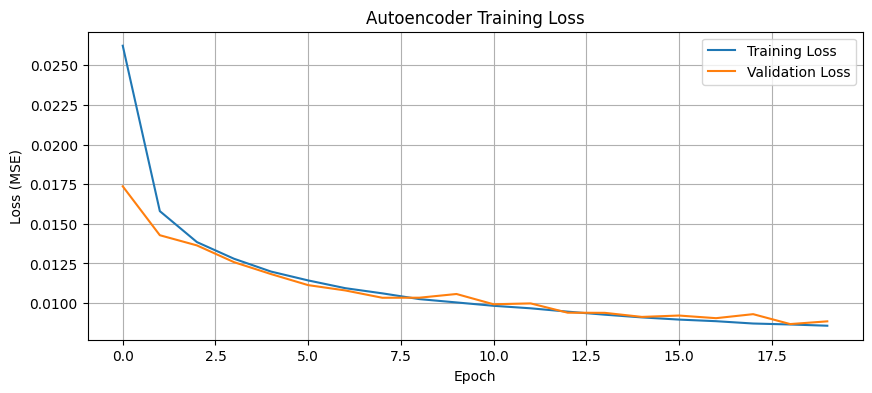

In [ ]:
# Plot training history
plt.figure(figsize=(10, 4))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Autoencoder Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss (MSE)')
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
# Evaluate autoencoder
print("\nEvaluating autoencoder performance...")
ae_metrics, decoded_imgs, x_test_noisy = evaluate_autoencoder(
    autoencoder,
    x_test,
    x_test_masked
  )


Evaluating autoencoder performance...
313/313 ━━━━━━━━━━━━━━━━━━━━ 18s 57ms/step
Autoencoder Evaluation Metrics:
MSE: 0.0088
SSIM: 0.6480 (higher is better)
PSNR: 21.07 dB (higher is better)



Visualizing autoencoder reconstructions...


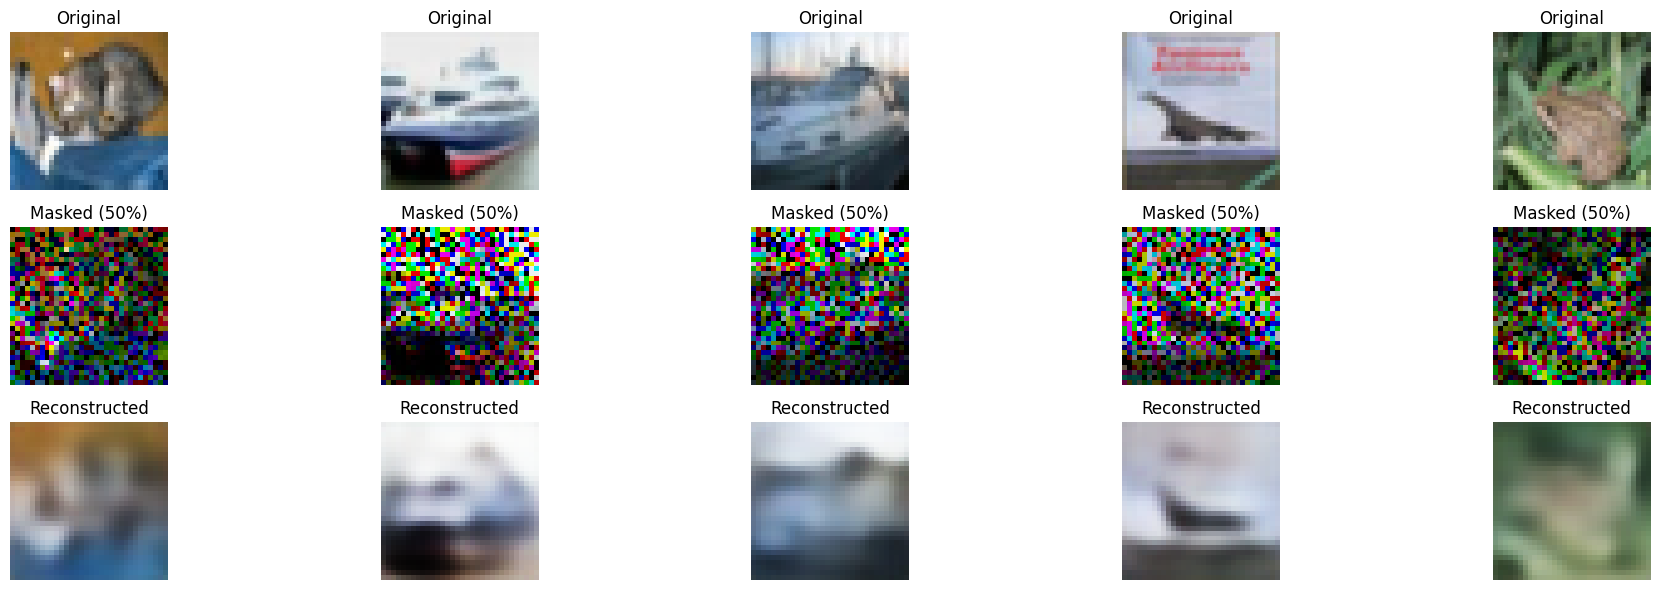

In [85]:
# Visualize results
print("\nVisualizing autoencoder reconstructions...")
visualize_autoencoder_results(x_test[:5], x_test_noisy[:5], decoded_imgs[:5])


Comparing ViT and Autoencoder performance...


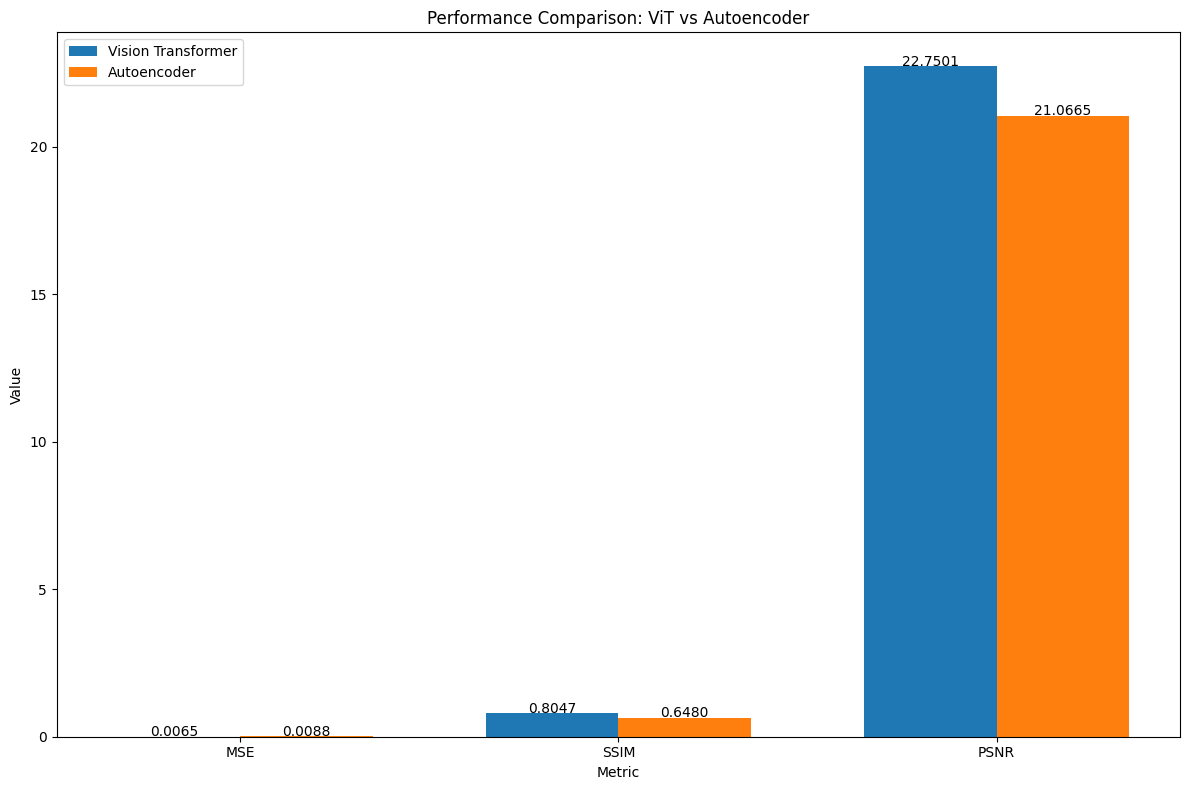


Performance Comparison Summary:
Metric     Vision Transformer   Autoencoder          Difference
------------------------------------------------------------
MSE        0.0065               0.0088               -0.0024    (ViT better)
SSIM       0.8047               0.6480               0.1567     (ViT better)
PSNR       22.7501              21.0665              1.6836     (ViT better)


In [ ]:
print("\nComparing ViT and Autoencoder performance...")
compare_vit_vs_autoencoder(metrics, ae_metrics)